# 4.2 Analysis of A/B testing from Game 3

In [1]:
from game.flaskapp_andrius.api import preprocesser
from game.utils import run_query
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns

from game.src.delta12_calculator import get_delta12_api, get_recipe_id_api, get_recipe_api, get_delta12
from game.src.ab_test_preprocessor import calc_new_delta, get_last_order_hist, get_all_orders, get_order_hist_from_observed
from game.src.feature_generator import get_embedding, get_vector_list

# Inputs

In [2]:
order_history = pd.read_csv('../data/order_history_g3.csv', sep=',')

In [3]:
g_observed = pd.read_csv('../data/game3.csv')

# Change csv output path at the end

# Preprocessing

In [4]:
g_observed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   record_id    756 non-null    int64
 1   customer_id  756 non-null    int64
 2   que1_rc1     756 non-null    int64
 3   que1_rc2     756 non-null    int64
 4   que1_rc3     756 non-null    int64
 5   que1_rc4     756 non-null    int64
 6   que1_rc5     756 non-null    int64
 7   que2_rc1     756 non-null    int64
 8   que2_rc2     756 non-null    int64
 9   que2_rc3     756 non-null    int64
 10  que2_rc4     756 non-null    int64
 11  que2_rc5     756 non-null    int64
dtypes: int64(12)
memory usage: 71.0 KB


In [5]:
recipe_cols = g_observed.columns[2:22]
recipe_cols

Index(['que1_rc1', 'que1_rc2', 'que1_rc3', 'que1_rc4', 'que1_rc5', 'que2_rc1',
       'que2_rc2', 'que2_rc3', 'que2_rc4', 'que2_rc5'],
      dtype='object')

In [6]:
# Game 3 specific processing. Remove entries where customers have chosen broken links
for i in recipe_cols:
    g_observed = g_observed[g_observed[i]!=3]
    g_observed = g_observed[g_observed[i]!=19]
    g_observed = g_observed[g_observed[i]!=45]
    g_observed = g_observed[g_observed[i]!=4]

# Remove instance where someone answered twice...
g_observed = g_observed[g_observed['record_id']!=160]

In [7]:
# Preprocessing order history table
order_history = order_history.reset_index()
order_history.columns = order_history.iloc[0].tolist()
order_history = order_history.drop(0)
order_history = order_history.dropna(subset=['id'])
order_history['id'] = order_history['id'].astype(int)
order_history['delivery_id'] = order_history['delivery_id'].astype(int)
order_history['customer_id'] = order_history['customer_id'].astype(int)
order_history.head(1)

,delivery_id,delivery_date,customer_id,allergens,calories,carbs,cuisine,fat,food_group,protein,...,id,cooking_time,image_url,instructions,key_ingredient,title,description,price_1p_pence,price_2p_pence,price_4p_pence
1,8090304,2020-03-26,100147,{Fish},517.77,39.44,British,25.24,Fish,33.14,...,875,15,https://mindfulchef-uat.imgix.net/recipes/875/...,"Boil a kettle., Peel and chop the sweet potato...","Fresh, sustainably caught cod fillet","Cod with sunflower seed, mint & basil pesto",This healthy fish dish brings summery vibes to...,1200,1800,NaN


In [8]:
g_customers = order_history['customer_id'].unique()
g_historical = pd.DataFrame(g_customers, columns=['customer_id'])

In [9]:
# Get updated recipes info and vectors associated with recipes
df_updated_recipes = pd.read_csv('../data/recipe_table_updated_UAT.csv', sep=',')
df_updated_recipes = df_updated_recipes.reset_index()
df_updated_recipes.columns = df_updated_recipes.iloc[0].tolist()
df_updated_recipes = df_updated_recipes.drop(0)
df_updated_recipes['id'] = df_updated_recipes['id'].astype(int)
df_updated_recipes = df_updated_recipes.dropna(subset=['key_ingredient'])

updated_recipe_dict = df_updated_recipes.to_dict(orient='records')
list_of_updated_vectors = get_vector_list(updated_recipe_dict)
df_updated_recipes['vector'] = list_of_updated_vectors
df_updated_recipes.head(1)

,allergens,calories,carbs,cuisine,fat,food_group,protein,season,special,id,cooking_time,image_url,instructions,key_ingredient,title,description,price_1p_pence,price_2p_pence,price_4p_pence,vector
1,"{Mustard,Nuts}",505.84,26.63,British,26.52,Beef,45.71,Spring,NaN,1,25,https://mindfulchef-uat.imgix.net/recipes/1/2e...,"Preheat the oven to 180C / gas mark 4., Trim t...",Grass-fed heritage breed Yorkshire beef,Seared beef with spring vegetable medley,We've paired a succulent seared steak with a m...,900,1400,2400,"[0.0647217469599511, -0.003410175382256585, -0..."


In [10]:
# Preprocessing of observed data from AB testing
g_observed = g_observed.dropna(subset=['customer_id'])
g_observed['customer_id'] = g_observed['customer_id'].astype(int)
g_observed[recipe_cols] = g_observed[recipe_cols].replace(0, np.nan)

In [11]:
# Generate recipe vectors from old recipe table
df_recipes = pd.read_csv('../data/recipe_table.csv', sep=';')
df_recipes['price'] = df_recipes['price_2p_pence']

df_clean = df_recipes[['id', 'food_group', 'calories', 'carbs', 'fat',
                      'protein', 'cooking_time', 'title', 'description',
                      'key_ingredient', 'price']]
recipe_dict = df_clean.to_dict(orient='records')
list_of_vectors = get_vector_list(recipe_dict)
df_clean['vector'] = list_of_vectors
df_vectors = pd.DataFrame(df_clean[['id', 'vector']])

# Historical delta12 and magnitude

In [12]:
# Get historical delta12 values for game-playing customers (can take time)
g_historical['historical_delta12'] = g_historical['customer_id'].apply(lambda x: get_delta12(get_last_order_hist(order_history, x)))

In [13]:
# Get historical pairwise magnitudes for game-playing customers (can take time)
g_historical['historical_magnitude'] = g_historical['customer_id'].apply(lambda x: calc_new_delta(get_all_orders(order_history, x), df_updated_recipes))

In [14]:
g_historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677 entries, 0 to 676
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           677 non-null    int32  
 1   historical_delta12    677 non-null    float64
 2   historical_magnitude  676 non-null    float64
dtypes: float64(2), int32(1)
memory usage: 13.3 KB


<AxesSubplot:xlabel='historical_delta12', ylabel='Density'>

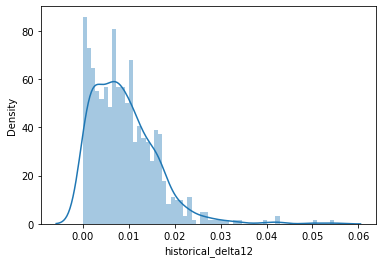

In [15]:
sns.distplot(g_historical['historical_delta12'], bins=60)

<AxesSubplot:xlabel='historical_magnitude', ylabel='Density'>

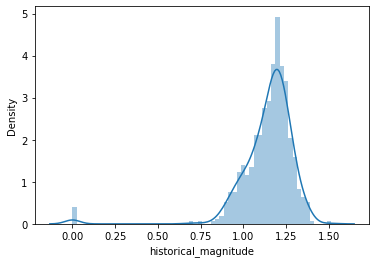

In [16]:
sns.distplot(g_historical['historical_magnitude'], bins=60)

In [17]:
# Sort by customer ID
g_historical = g_historical.sort_values('customer_id')
g_historical.head(5)

,customer_id,historical_delta12,historical_magnitude
284,240,0.000041,1.142805
523,772,0.002073,1.007583
273,2028,0.014490,0.929246
296,2722,0.003879,1.209103
310,3073,0.016507,1.206433


# Observed delta12 and magnitude from AB testing

In [18]:
# Get observed delta12 values
g_observed['observed_delta12'] = g_observed['customer_id'].apply(lambda x: get_delta12(get_order_hist_from_observed(g_observed, x, recipe_cols)))
g_observed.head(1)

,record_id,customer_id,que1_rc1,que1_rc2,que1_rc3,que1_rc4,que1_rc5,que2_rc1,que2_rc2,que2_rc3,que2_rc4,que2_rc5,observed_delta12
0,1,39490,397,158,760,954,282,650,318,734,573,323,0.001929


In [19]:
# Get observed magnitudes (this takes some time to run)
g_observed['observed_magnitude']=0
for i in range(len(g_observed)):
    g_observed['observed_magnitude'].iloc[i] = calc_new_delta(g_observed[recipe_cols].iloc[i].dropna().tolist(), df_vectors)

In [20]:
g_observed_clean = g_observed[['customer_id', 'observed_delta12', 'observed_magnitude']]
g_observed_clean = g_observed_clean.sort_values('customer_id')
g_observed_clean.head(5)

,customer_id,observed_delta12,observed_magnitude
6,240,0.008333,1.488437
547,772,0.028166,1.361732
192,2028,0.006449,1.377243
202,2722,0.012164,1.178893
204,2722,0.012164,1.300297


In [21]:
g_historical.head(5)

,customer_id,historical_delta12,historical_magnitude
284,240,0.000041,1.142805
523,772,0.002073,1.007583
273,2028,0.014490,0.929246
296,2722,0.003879,1.209103
310,3073,0.016507,1.206433


# Merge and export

In [22]:
g_merged = pd.merge(g_historical, g_observed_clean, on='customer_id')

In [23]:
g_merged['diff_delta12'] = g_merged['observed_delta12'] - g_merged['historical_delta12']
g_merged['diff_magnitude'] = g_merged['observed_magnitude'] - g_merged['historical_magnitude']
g_merged.head()

,customer_id,historical_delta12,historical_magnitude,observed_delta12,observed_magnitude,diff_delta12,diff_magnitude
0,240,0.000041,1.142805,0.008333,1.488437,0.008292,0.345631
1,772,0.002073,1.007583,0.028166,1.361732,0.026093,0.354149
2,2028,0.014490,0.929246,0.006449,1.377243,-0.008041,0.447997
3,2722,0.003879,1.209103,0.012164,1.178893,0.008285,-0.030210
4,2722,0.003879,1.209103,0.012164,1.300297,0.008285,0.091193


<AxesSubplot:xlabel='diff_delta12', ylabel='Density'>

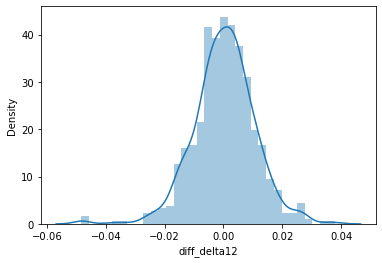

In [24]:
sns.distplot(g_merged['diff_delta12'])

<AxesSubplot:xlabel='diff_magnitude', ylabel='Density'>

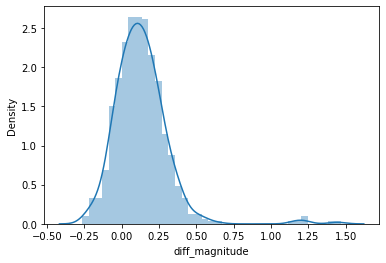

In [25]:
sns.distplot(g_merged['diff_magnitude'])

In [26]:
g_merged['diff_delta12'].describe()

count    689.000000
mean       0.000264
std        0.010491
min       -0.048392
25%       -0.005705
50%        0.000430
75%        0.006150
max        0.038090
Name: diff_delta12, dtype: float64

In [27]:
g_merged['diff_magnitude'].describe()

count    688.000000
mean       0.130275
std        0.185882
min       -0.266775
25%        0.015555
50%        0.115677
75%        0.214177
max        1.471113
Name: diff_magnitude, dtype: float64

In [29]:
# Export data
g_merged[['diff_delta12', 'diff_magnitude']].to_csv('../data/g3_diff.csv', index=False)